# Dask + Emcee tutorial

In our first tutorial, we learned how to set up `Dask` on TIKE and perform some basic calculations. In the process, we convinced ourselves that it was indeed possible to speed up code by using `Dask`'s parallelization.

That problem, however, was a bit of a "toy problem." Let's go a step further and use Dask to do some real science.

emcee is a popular tool used for scientific inference. 

As in the first tutorial notebook, we'll first set up our Python and package versions so that all the `Dask` functionality works as expected.

In [1]:
from platform import python_version

print(python_version())

3.11.7


In [2]:
!conda install python=3.11.7 -y

Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/tess

  added / updated specs:
    - python=3.11.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.6.15  |       hbd8a1cb_0         148 KB  conda-forge
    liblzma-devel-5.8.1        |       hb9d3cd8_1         431 KB  conda-forge
    xz-5.8.1                   |       hbcc6ac9_1          23 KB  conda-forge
    xz-gpl-tools-5.8.1         |       hbcc6ac9_1          33 KB  conda-forge
    xz-tools-5.8.1             |       hb9d3cd8_1          94 KB  conda-forge
    ------------------------------------------------------------
  

In [2]:
from platform import python_version

print(python_version())

3.11.7


In [3]:
!pip install dask[dataframe]==2024.1.0 distributed==2024.1.0 msgpack==1.0.7 pandas==2.1.4 numpy==1.26.3 toolz==0.12.0 tornado==6.4 dask_gateway

  Using cached dask-2024.1.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached distributed-2024.1.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached msgpack-1.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached toolz-0.12.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached tornado-6.4-cp38-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached dask_gateway-2025.4.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached tblib-3.1.0-py3-none-any.whl.metadata (25 kB)
  Using cached zict-3.0.0-py2.py3-none-any.whl.metadata (899 bytes)
Using cached dask-2024.1.0-py3-none-any.whl (1.2 MB)
Using cached dist

In [28]:
import time

import astropy.units as u
import dask
import emcee
import dask.array as da
# import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
import corner
from tqdm import tqdm

from astroquery.mast import Observations, Catalogs
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from dask import delayed, compute
from dask.dataframe.utils import make_meta
from dask.diagnostics import ProgressBar  # Import the ProgressBar
from dask_gateway import Gateway, GatewayCluster
from distributed.diagnostics.plugin import PipInstall

# Import necessary libraries
import numpy as np
import os
import psutil
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display, HTML

# Import Dask components
import dask
from dask.distributed import Client, performance_report, wait

from dask.distributed import performance_report

import time
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import psutil
import os
from dask_gateway import Gateway, GatewayCluster

import numpy as np
import pandas as pd
import os
import psutil
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display, HTML

# Import Dask components
import dask
from dask.distributed import Client, performance_report, wait

In [5]:
gateway = Gateway(address="http://traefik-dask-gateway", auth="jupyterhub")

In [6]:
cluster = gateway.new_cluster()

In [7]:
cluster

In [8]:
# Adaptively scale between 2 and 3 workers
cluster.adapt(minimum=2, maximum=3)

In [9]:
client = cluster.get_client()
client

/opt/conda/envs/tess/lib/python3.11/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| lz4     | 4.4.4  | None      | None    |
| tornado | 6.4.1  | 6.4       | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: http://traefik-dask-gateway/clusters/default.68b6e8649a5f44f6a77da47200abe43e/status,


We'll also include emcee as a package to install on the client.

In [23]:
plugin = PipInstall(packages=[
    "tornado==6.4.1",
    "lz4==4.4.4",
    "emcee",
    "batman"
])

# essentially pip installs the package on the cluster
client.register_plugin(plugin)

## Coupling with emcee

In [14]:
class DaskPool:
    def __init__(self, client):
        self.client = client
        self._owns_client = False  # Track if we should close the client
    def map(self, func, iterable):
        futures = self.client.map(func, iterable)
        return self.client.gather(futures)
    
    def close(self):
        # Only close if we own the client
        if self._owns_client:
            self.client.close()
    
    def terminate(self):
        # Only shutdown if we own the client
        if self._owns_client:
            self.client.shutdown()
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()


In [15]:
# Generate synthetic data: y = mx + b + noise
def generate_data(n_points=50, true_slope=2.5, true_intercept=1.3, noise_level=0.5):
    """Generate noisy linear data"""
    np.random.seed(42)  # For reproducible results
    x = np.linspace(0, 10, n_points)
    y_true = true_slope * x + true_intercept
    y_obs = y_true + np.random.normal(0, noise_level, n_points)
    y_err = np.full_like(y_obs, noise_level)  # Assume known uncertainties
    
    return x, y_obs, y_err, (true_slope, true_intercept)

In [16]:
# Log probability function for linear regression
def log_prob(theta, x, y, yerr):
    """
    Log probability for linear regression: y = mx + b
    theta = [slope, intercept, log_scatter]
    """
    slope, intercept, log_scatter = theta
    
    # Model prediction
    model = slope * x + intercept
    
    # Total variance (measurement error + intrinsic scatter)
    scatter = np.exp(log_scatter)
    sigma2 = yerr**2 + scatter**2
    
    # Log likelihood (assuming Gaussian errors)
    log_likelihood = -0.5 * np.sum((y - model)**2 / sigma2 + np.log(2 * np.pi * sigma2))
    
    # Priors (weakly informative)
    # slope: normal around 0, wide
    # intercept: normal around 0, wide  
    # log_scatter: uniform (effectively log-uniform prior on scatter)
    if (-10 < slope < 10 and -10 < intercept < 10 and -5 < log_scatter < 2):
        log_prior = 0.0  # Flat priors within bounds
    else:
        log_prior = -np.inf
    
    return log_likelihood + log_prior


In [18]:
print("🔍 Generating test data...")
x, y, yerr, true_params = generate_data()
true_slope, true_intercept = true_params

print(f"True parameters: slope={true_slope:.2f}, intercept={true_intercept:.2f}")

# MCMC setup
ndim = 3  # slope, intercept, log_scatter
nwalkers = 32
nsteps = 1000
nburn = 300

# Initialize walkers near the true solution
pos = np.array([
    np.random.normal(true_slope, 0.1, nwalkers),      # slope
    np.random.normal(true_intercept, 0.1, nwalkers),  # intercept  
    np.random.normal(-1, 0.1, nwalkers)               # log_scatter
]).T

🔍 Generating test data...
True parameters: slope=2.50, intercept=1.30


In [24]:
# Run MCMC with Dask
with DaskPool(client) as pool:
    print(f"Dask dashboard: {pool.client.dashboard_link}")
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, 
        args=(x, y, yerr),
        pool=pool
    )
    
    # Burn-in
    print(f"Running burn-in ({nburn} steps)...")
    pos = sampler.run_mcmc(pos, nburn, progress=True)
    sampler.reset()
    
    # Production run
    print(f"Running production ({nsteps} steps)...")
    sampler.run_mcmc(pos, nsteps, progress=True)

Dask dashboard: http://traefik-dask-gateway/clusters/default.68b6e8649a5f44f6a77da47200abe43e/status
Running burn-in (300 steps)...


100%|██████████| 300/300 [00:23<00:00, 12.79it/s]


Running production (1000 steps)...


100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]


In [25]:
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

# Get samples and compute statistics
samples = sampler.get_chain(discard=0, thin=15, flat=True)

# Parameter estimates
slope_samples = samples[:, 0]
intercept_samples = samples[:, 1]
scatter_samples = np.exp(samples[:, 2])  # Convert back from log

# Summary statistics
slope_med = np.median(slope_samples)
slope_err = np.std(slope_samples)
intercept_med = np.median(intercept_samples)
intercept_err = np.std(intercept_samples)
scatter_med = np.median(scatter_samples)

print(f"Estimated slope: {slope_med:.3f} ± {slope_err:.3f} (true: {true_slope:.3f})")
print(f"Estimated intercept: {intercept_med:.3f} ± {intercept_err:.3f} (true: {true_intercept:.3f})")
print(f"Estimated scatter: {scatter_med:.3f}")

Mean acceptance fraction: 0.620
Estimated slope: 2.472 ± 0.024 (true: 2.500)
Estimated intercept: 1.324 ± 0.135 (true: 1.300)
Estimated scatter: 0.030


In [26]:
# Check if estimates are reasonable (within 2-sigma)
slope_ok = abs(slope_med - true_slope) < 2 * slope_err
intercept_ok = abs(intercept_med - true_intercept) < 2 * intercept_err

print(f"\n✅ Test Results:")
print(f"Slope recovery: {'PASS' if slope_ok else 'FAIL'}")
print(f"Intercept recovery: {'PASS' if intercept_ok else 'FAIL'}")


✅ Test Results:
Slope recovery: PASS
Intercept recovery: PASS


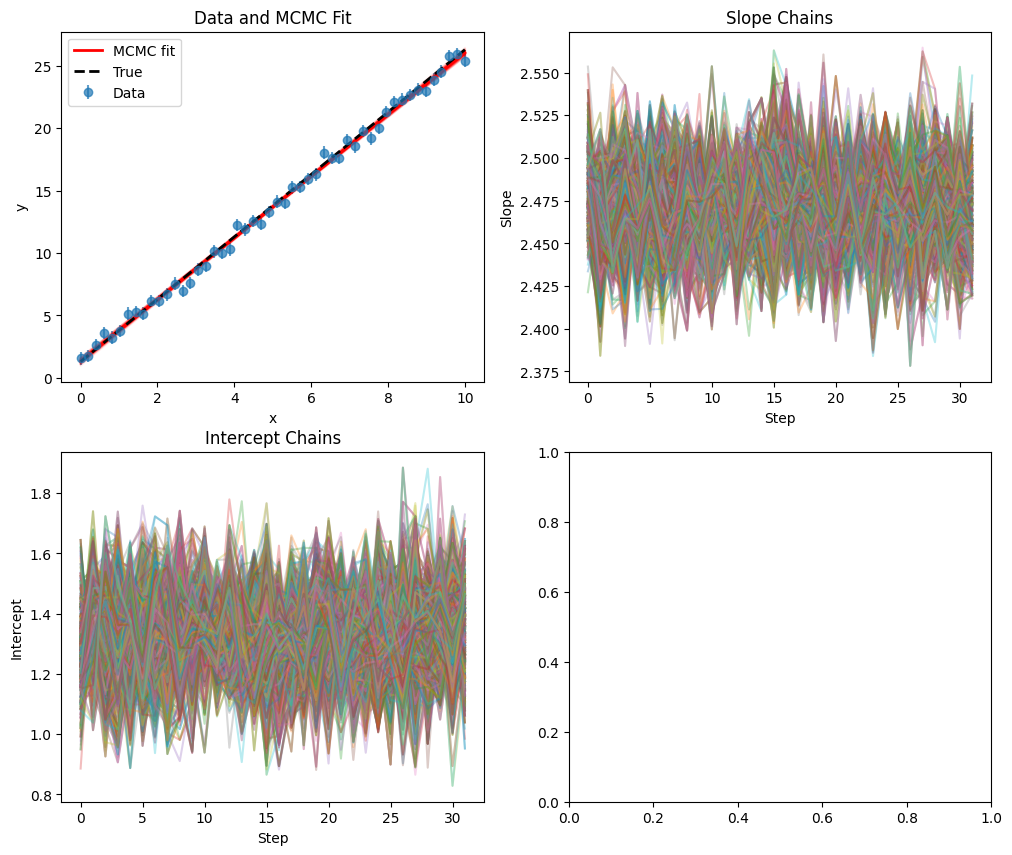

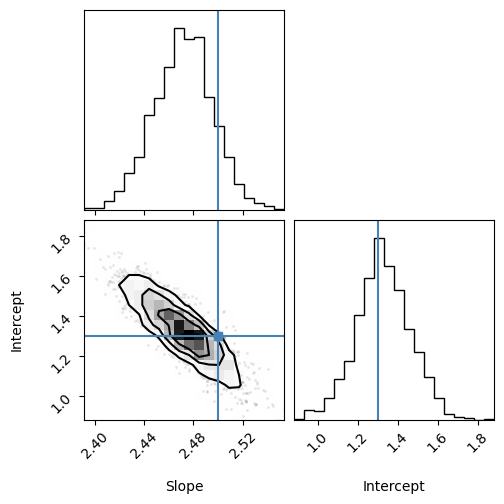

In [33]:
# Make plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Data and fit
ax = axes[0, 0]
ax.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.7, label='Data')

# Plot some sample fits
for i in np.random.choice(len(samples), 100):
    m, b = samples[i, 0], samples[i, 1]
    ax.plot(x, m*x + b, color='red', alpha=0.05)

# Best fit
ax.plot(x, slope_med*x + intercept_med, 'r-', linewidth=2, label='MCMC fit')
ax.plot(x, true_slope*x + true_intercept, 'k--', linewidth=2, label='True')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Data and MCMC Fit')

# Chain traces
ax = axes[0, 1]
ax.plot(sampler.get_chain()[:, :, 0].T, alpha=0.3)
ax.set_ylabel('Slope')
ax.set_xlabel('Step')
ax.set_title('Slope Chains')

ax = axes[1, 0] 
ax.plot(sampler.get_chain()[:, :, 1].T, alpha=0.3)
ax.set_ylabel('Intercept')
ax.set_xlabel('Step')
ax.set_title('Intercept Chains')

# Corner plot (if corner is available)
ax = axes[1, 1]
ax.remove()
ax = fig.add_subplot(2, 2, 4)
corner.corner(samples[:, :2], labels=['Slope', 'Intercept'], 
             truths=[true_slope, true_intercept]);
# ax.set_title('Parameter Posterior')


In [36]:
# now see if that's faster
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, 
    args=(x, y, yerr),
)

# Burn-in
print(f"Running burn-in ({nburn} steps)...")
pos = sampler.run_mcmc(pos, nburn, progress=True)
sampler.reset()

# Production run
print(f"Running production ({nsteps} steps)...")
sampler.run_mcmc(pos, nsteps, progress=True);

Running burn-in (300 steps)...


100%|██████████| 300/300 [00:00<00:00, 1381.79it/s]


Running production (1000 steps)...


100%|██████████| 1000/1000 [00:00<00:00, 1296.69it/s]


In [37]:
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

# Get samples and compute statistics
samples = sampler.get_chain(discard=0, thin=15, flat=True)

# Parameter estimates
slope_samples = samples[:, 0]
intercept_samples = samples[:, 1]
scatter_samples = np.exp(samples[:, 2])  # Convert back from log

# Summary statistics
slope_med = np.median(slope_samples)
slope_err = np.std(slope_samples)
intercept_med = np.median(intercept_samples)
intercept_err = np.std(intercept_samples)
scatter_med = np.median(scatter_samples)

print(f"Estimated slope: {slope_med:.3f} ± {slope_err:.3f} (true: {true_slope:.3f})")
print(f"Estimated intercept: {intercept_med:.3f} ± {intercept_err:.3f} (true: {true_intercept:.3f})")
print(f"Estimated scatter: {scatter_med:.3f}")

Mean acceptance fraction: 0.616
Estimated slope: 2.469 ± 0.024 (true: 2.500)
Estimated intercept: 1.342 ± 0.136 (true: 1.300)
Estimated scatter: 0.034


In [38]:
# Check if estimates are reasonable (within 2-sigma)
slope_ok = abs(slope_med - true_slope) < 2 * slope_err
intercept_ok = abs(intercept_med - true_intercept) < 2 * intercept_err

print(f"\n✅ Test Results:")
print(f"Slope recovery: {'PASS' if slope_ok else 'FAIL'}")
print(f"Intercept recovery: {'PASS' if intercept_ok else 'FAIL'}")


✅ Test Results:
Slope recovery: PASS
Intercept recovery: PASS


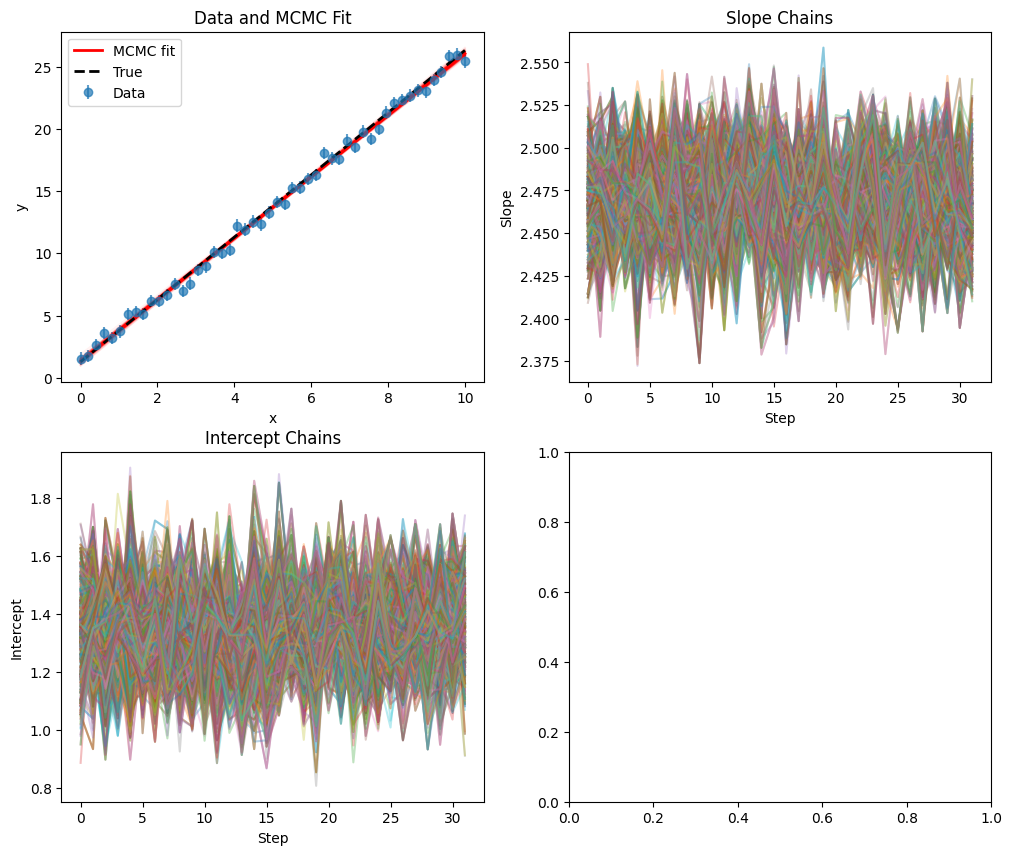

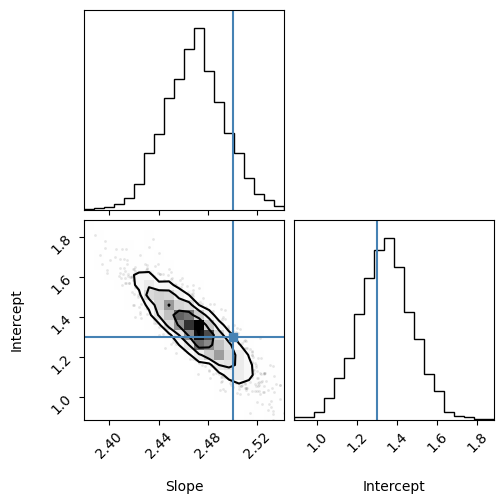

In [39]:
# Make plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Data and fit
ax = axes[0, 0]
ax.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.7, label='Data')

# Plot some sample fits
for i in np.random.choice(len(samples), 100):
    m, b = samples[i, 0], samples[i, 1]
    ax.plot(x, m*x + b, color='red', alpha=0.05)

# Best fit
ax.plot(x, slope_med*x + intercept_med, 'r-', linewidth=2, label='MCMC fit')
ax.plot(x, true_slope*x + true_intercept, 'k--', linewidth=2, label='True')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Data and MCMC Fit')

# Chain traces
ax = axes[0, 1]
ax.plot(sampler.get_chain()[:, :, 0].T, alpha=0.3)
ax.set_ylabel('Slope')
ax.set_xlabel('Step')
ax.set_title('Slope Chains')

ax = axes[1, 0] 
ax.plot(sampler.get_chain()[:, :, 1].T, alpha=0.3)
ax.set_ylabel('Intercept')
ax.set_xlabel('Step')
ax.set_title('Intercept Chains')

# Corner plot (if corner is available)
ax = axes[1, 1]
ax.remove()
ax = fig.add_subplot(2, 2, 4)
corner.corner(samples[:, :2], labels=['Slope', 'Intercept'], 
             truths=[true_slope, true_intercept]);
# ax.set_title('Parameter Posterior')


In [102]:
# it works, just slower! let's not fit a line to data

# Ideas for what to fit
- black hole m-sigma relation
- yeah maybe just fit a transit

In [ ]:
import batman

In [ ]:
def generate_transit_data(n_points=200, noise_level=0.001):
    """
    Generate synthetic transit light curve with batman
    """
    # True transit parameters
    true_params = {
        't0': 0.0,          # Transit center time
        'per': 3.5,         # Orbital period (days) 
        'rp': 0.1,          # Planet radius (stellar radii)
        'a': 12.0,          # Semi-major axis (stellar radii)
        'inc': 87.0,        # Inclination (degrees)
        'ecc': 0.0,         # Eccentricity
        'w': 90.0,          # Longitude of periastron (degrees)
        'limb_dark': "quadratic",  # Limb darkening law
        'u': [0.3, 0.2]     # Limb darkening coefficients
    }
    
    # Set up batman parameters
    params = batman.TransitParams()
    for key, value in true_params.items():
        setattr(params, key, value)
    
    # Time array spanning transit
    time = np.linspace(-0.15, 0.15, n_points)  # 0.3 days around transit
    
    # Calculate true light curve
    m = batman.TransitModel(params, time)
    flux_true = m.light_curve(params)
    
    # Add noise
    np.random.seed(42)
    flux_obs = flux_true + np.random.normal(0, noise_level, n_points)
    flux_err = np.full_like(flux_obs, noise_level)
    
    return time, flux_obs, flux_err, true_params

In [103]:
def transit_model(theta, time):
    """
    Calculate transit light curve for given parameters
    theta = [t0, rp, a, inc]
    """
    t0, rp, a, inc = theta
    
    # Set up batman parameters (fixed values)
    params = batman.TransitParams()
    params.t0 = t0
    params.per = 3.5         # Fixed period
    params.rp = rp
    params.a = a
    params.inc = inc
    params.ecc = 0.0         # Fixed circular orbit
    params.w = 90.0          # Fixed
    params.limb_dark = "quadratic"
    params.u = [0.3, 0.2]    # Fixed limb darkening
    
    # Calculate model
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

In [ ]:
def log_prob(theta, time, flux, flux_err):
    """
    Log probability function for transit fitting
    theta = [t0, rp, a, inc]
    """
    t0, rp, a, inc = theta
    
    # Priors
    if not (-0.05 < t0 < 0.05):          # Transit time prior
        return -np.inf
    if not (0.05 < rp < 0.2):            # Planet radius prior
        return -np.inf  
    if not (8.0 < a < 20.0):             # Semi-major axis prior
        return -np.inf
    if not (80.0 < inc < 90.0):          # Inclination prior (nearly edge-on)
        return -np.inf
    
    try:
        # Calculate model light curve
        model = transit_model(theta, time)
        
        # Log likelihood (Gaussian)
        chi2 = np.sum(((flux - model) / flux_err) ** 2)
        log_likelihood = -0.5 * chi2
        
        return log_likelihood
        
    except Exception:
        # Batman can fail for unphysical parameters
        return -np.inf


In [ ]:
time, flux, flux_err, true_params = generate_transit_data(n_points=50000,noise_level=0.01)

print("True parameters:")
print(f"  t0 = {true_params['t0']:.4f}")
print(f"  rp = {true_params['rp']:.4f}")
print(f"  a = {true_params['a']:.2f}")
print(f"  inc = {true_params['inc']:.2f}°")

# Plot data
plt.figure(figsize=(10, 6))
plt.errorbar(time, flux, yerr=flux_err, fmt='o', alpha=0.7, 
             markersize=3, label='Synthetic data')

# Plot true model
true_theta = [true_params['t0'], true_params['rp'], 
              true_params['a'], true_params['inc']]
true_model = transit_model(true_theta, time)
plt.plot(time, true_model, 'r-', linewidth=2, label='True model')

In [ ]:
# MCMC setup
ndim = 4  # t0, rp, a, inc
nwalkers = 64
nburn = 200
n_steps=1000

pos = np.array([
        np.random.normal(true_params['t0'], 0.001, nwalkers),    # t0
        np.random.normal(true_params['rp'], 0.005, nwalkers),    # rp  
        np.random.normal(true_params['a'], 0.2, nwalkers),       # a
        np.random.normal(true_params['inc'], 0.5, nwalkers)      # inc
    ]).T

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob,
    args=(time, flux, flux_err)
)

# Burn-in
print(f"Burn-in phase ({nburn} steps)...")
pos = sampler.run_mcmc(pos, nburn, progress=True)
sampler.reset()

# Production run
print(f"Production run ({n_steps} steps)...")
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
param_names = ['t0', 'rp', 'a', 'inc']
true_values = [true_params['t0'], true_params['rp'], 
                   true_params['a'], true_params['inc']]

In [ ]:
samples = sampler.get_chain(discard=0, thin=10, flat=True)

In [ ]:
# Make corner plot
corner.corner(samples, labels=param_names, 
                   truths=true_values)
# plt.suptitle('Transit Parameter Posterior', y=1.02)
# plt.show()


# Plot best-fit model
best_theta = np.median(samples, axis=0)
best_model = transit_model(best_theta, time)

plt.figure(figsize=(12, 8))

# Data and models
plt.subplot(2, 1, 1)
plt.errorbar(time, flux, yerr=flux_err, fmt='o', alpha=0.7, 
             markersize=3, label='Data')
plt.plot(time, true_model, 'r-', linewidth=2, label='True model', zorder=100)
plt.plot(time, best_model, 'b--', linewidth=2, label='MCMC fit', zorder=100)

# Plot sample of posterior models
for i in np.random.choice(len(samples), 50):
    model_i = transit_model(samples[i], time)
    plt.plot(time, model_i, 'gray', alpha=0.1)

plt.ylabel('Relative flux')
plt.legend()
plt.title('Transit Fit Results')
plt.grid(True, alpha=0.3)

# Residuals
plt.subplot(2, 1, 2)
residuals = flux - best_model
plt.errorbar(time, residuals, yerr=flux_err, fmt='o', alpha=0.7, markersize=3)
plt.axhline(0, color='red', linestyle='--', zorder=100)
plt.ylabel('Residuals')
plt.xlabel('Time from transit center (days)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# and now try with the pooool again
# Run MCMC with Dask
with DaskPool(client) as pool:
    print(f"Dask dashboard: {pool.client.dashboard_link}")
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, 
        args=(x, y, yerr),
        pool=pool
    )
    
    # Burn-in
    print(f"Running burn-in ({nburn} steps)...")
    pos = sampler.run_mcmc(pos, nburn, progress=True)
    sampler.reset()
    
    # Production run
    print(f"Running production ({nsteps} steps)...")
    sampler.run_mcmc(pos, nsteps, progress=True)

In [ ]:
# 2x speedup, nice!